In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoImageProcessor, AutoModel
from tqdm import tqdm

2025-08-10 19:09:55.959705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754852995.982810     214 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754852995.989820     214 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
score = pd.read_csv('/kaggle/input/spaq-10k/MOS and Image attribute scores.xlsx - Sheet1.csv')
scene = pd.read_excel('/kaggle/input/spaq-10k/Scene category labels.xlsx')

In [3]:
score.head(5)

,Image name,MOS,Brightness,Colorfulness,Contrast,Noisiness,Sharpness
0,00001.jpg,48.86,47.43,55.57,55.71,37.86,42.57
1,00002.jpg,62.50,55.38,67.13,53.13,57.50,47.50
2,00003.jpg,77.25,62.38,72.63,65.75,72.25,82.71
3,00004.jpg,67.00,68.43,69.43,67.00,67.86,63.29
4,00005.jpg,22.71,54.29,62.14,51.00,38.43,15.57


In [4]:
scene.head(5)

,Image name,Animal,Cityscape,Human,Indoor scene,Landscape,Night scene,Plant,Still-life,Others
0,00001.jpg,0.0,0.333333,0.000000,0.000000,0.0,0.333333,0.0,0.333333,0.0
1,00002.jpg,0.0,0.500000,0.000000,0.000000,0.0,0.500000,0.0,0.000000,0.0
2,00003.jpg,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.0
3,00004.jpg,0.0,0.000000,0.333333,0.333333,0.0,0.000000,0.0,0.333333,0.0
4,00005.jpg,0.0,0.000000,0.000000,0.500000,0.0,0.000000,0.0,0.500000,0.0


In [5]:
scaler = MinMaxScaler()
score.iloc[:,1:] = scaler.fit_transform(score.iloc[:,1:])

In [6]:
low_mos = score[score['MOS'] < 0.5]
high_mos = score[score['MOS'] > 0.5]

low_sample = low_mos.sample(n=250, random_state=42)
high_sample = high_mos.sample(n=250, random_state=42)

test_df = pd.concat([low_sample, high_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

train_df = score.drop(test_df.index).reset_index(drop=True)

scene_test_df = scene[scene['Image name'].isin(test_df['Image name'])].reset_index(drop=True)
scene_train_df = scene[scene['Image name'].isin(train_df['Image name'])].reset_index(drop=True)

print(f"Train size (score): {len(train_df)}, Test size (score): {len(test_df)}")
print(f"Train size (scene): {len(scene_train_df)}, Test size (scene): {len(scene_test_df)}")

train_merged = pd.merge(train_df, scene_train_df, on="Image name", how="inner")
test_merged = pd.merge(test_df, scene_test_df, on="Image name", how="inner")

Train size (score): 10625, Test size (score): 500
Train size (scene): 10625, Test size (scene): 500


In [7]:
train_merged

,Image name,MOS,Brightness,Colorfulness,Contrast,Noisiness,Sharpness,Animal,Cityscape,Human,Indoor scene,Landscape,Night scene,Plant,Still-life,Others
0,00501.jpg,0.545213,0.695661,0.668094,0.658147,0.529253,0.351662,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00502.jpg,0.658723,0.788740,0.742077,0.779741,0.515041,0.622831,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00503.jpg,0.434255,0.521074,0.556745,0.543494,0.469087,0.485365,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,00504.jpg,0.813085,0.800000,0.796574,0.827706,0.802905,0.851035,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,00505.jpg,0.443298,0.571281,0.541435,0.584517,0.474378,0.263956,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10620,11121.jpg,0.278404,0.516219,0.457495,0.528348,0.481328,0.143529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10621,11122.jpg,0.770213,0.632231,0.775161,0.765752,0.792531,0.769183,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10622,11123.jpg,0.551064,0.555785,0.708779,0.589040,0.506224,0.549655,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10623,11124.jpg,0.361702,0.433884,0.503212,0.477543,0.450207,0.162868,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Frequency')

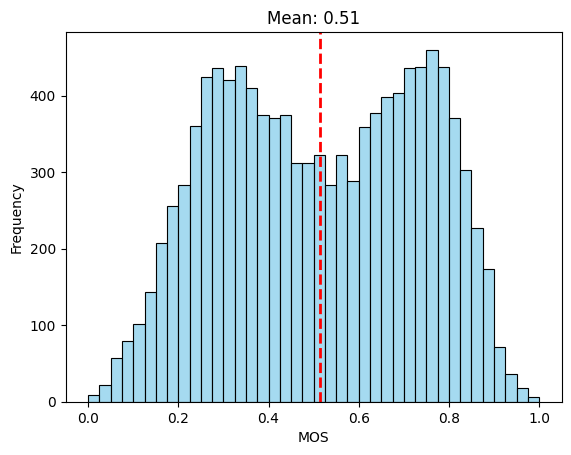

In [8]:
sns.histplot(score['MOS'], bins=40, color='skyblue', edgecolor='black')
plt.axvline(x=score['MOS'].mean(), color='red', linestyle='--', linewidth=2)
plt.title(f"Mean: {score['MOS'].mean():.2f}")
plt.xlabel("MOS")
plt.ylabel("Frequency")

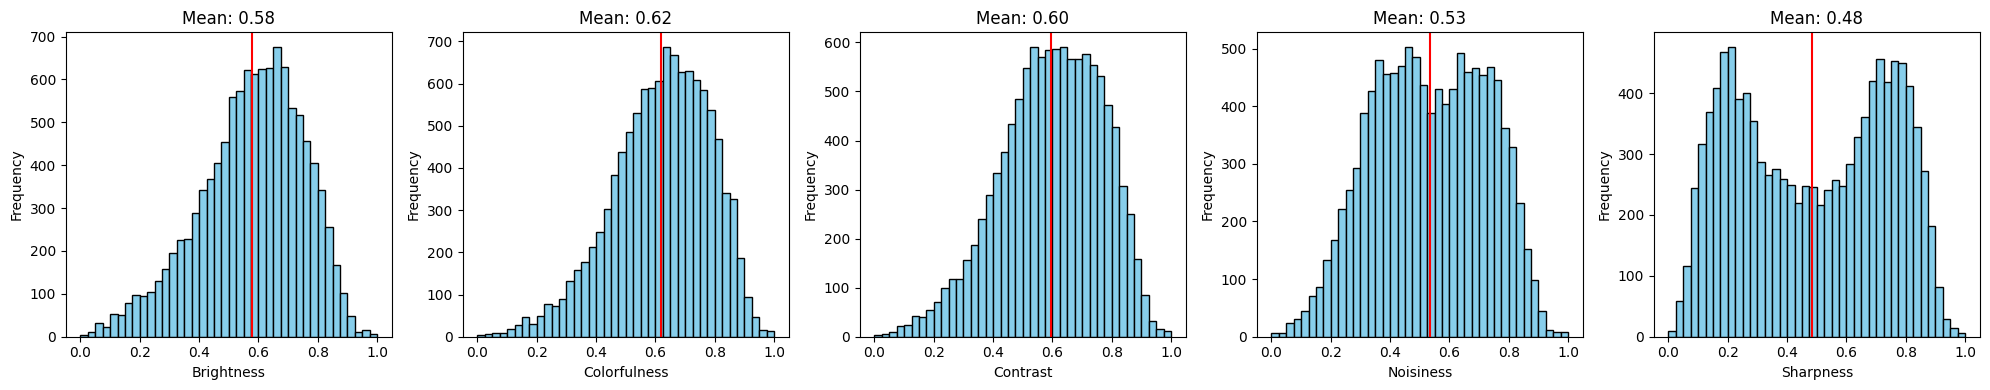

In [9]:
col_names = score.iloc[:,2:].columns

col_names = score.iloc[:, 2:].columns  
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  
for i, ax in enumerate(axes.flatten()):
    if i < len(col_names):
        ax.hist(score[col_names[i]], bins=40, color='skyblue', edgecolor='black')
        mean = score[col_names[i]].mean()
        ax.axvline(x=mean, color='red')
        ax.set_title(f'Mean: {mean:.2f}')
        ax.set_ylabel("Frequency")
        ax.set_xlabel(col_names[i])
plt.tight_layout()

<Axes: xlabel='Brightness', ylabel='Contrast'>

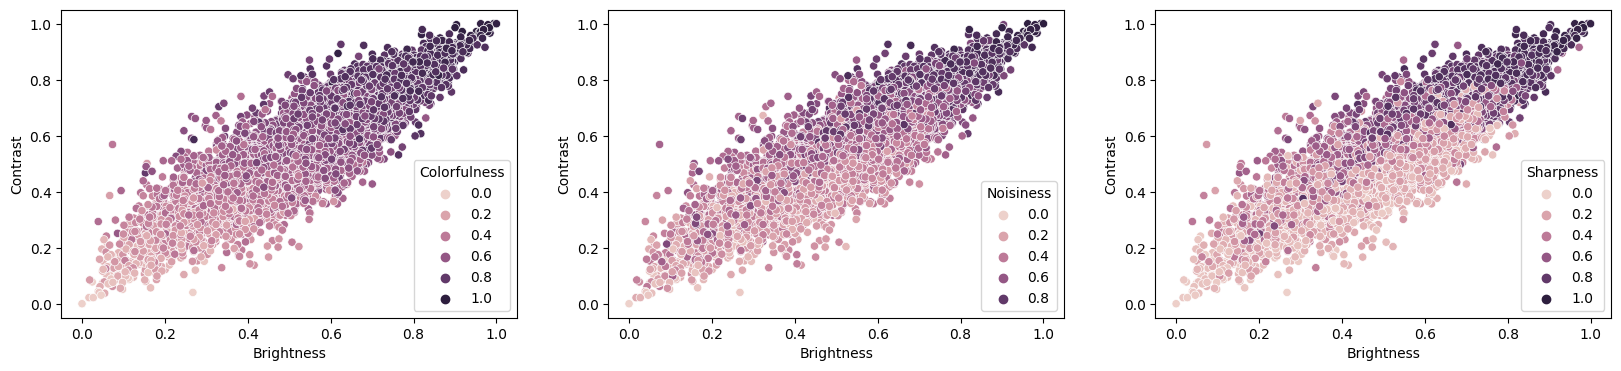

In [10]:
fig,ax = plt.subplots(1,3,figsize=(20,4))
sns.scatterplot(data=score,x='Brightness',y='Contrast',hue='Colorfulness',ax=ax[0])
sns.scatterplot(data=score,x='Brightness',y='Contrast',hue='Noisiness',ax=ax[1])
sns.scatterplot(data=score,x='Brightness',y='Contrast',hue='Sharpness',ax=ax[2])

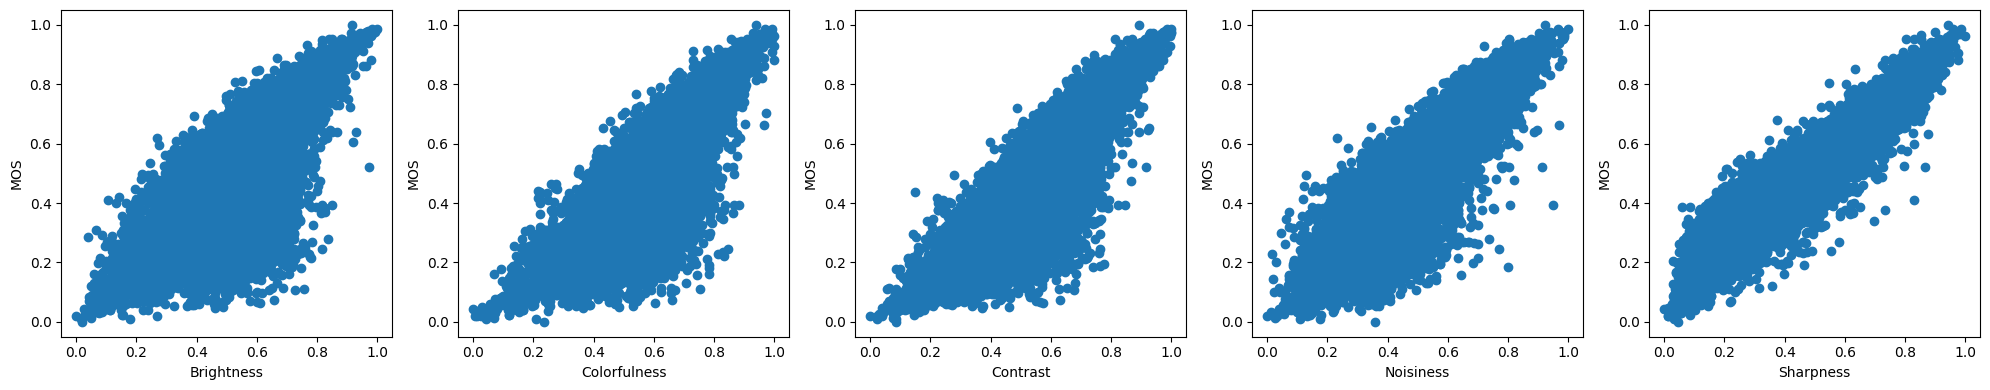

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  
for i, ax in enumerate(axes.flatten()):
    if i < len(col_names):
        ax.scatter(score[col_names[i]],score['MOS'])
        ax.set_ylabel("MOS")
        ax.set_xlabel(f'{col_names[i]}')
plt.tight_layout()

Text(0.5, 1.0, 'Scene Attributes')

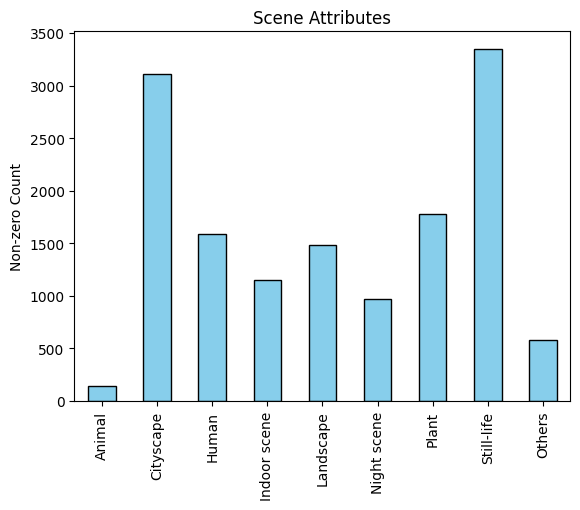

In [12]:
scene_attrs = scene.iloc[:, 1:]
nonzero_counts = (scene_attrs != 0).sum()
nonzero_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.ylabel("Non-zero Count")
plt.title("Scene Attributes")

### **Importing The Model**

In [13]:
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
encoder = AutoModel.from_pretrained("facebook/dinov2-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [15]:
for param in encoder.parameters():
    param.requires_grad=False

### **Creating The Dataset**

In [16]:
img_path = '/kaggle/input/spaq-10k/SPAQ_small'

In [17]:
class AssessmentDataset(Dataset):
    def __init__(self, df, img_path, processor):
        self.df = df
        self.img_path = img_path
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name = 	self.df.iloc[index]['Image name']
        img = Image.open(os.path.join(self.img_path, img_name)).convert("RGB")
        img = self.processor(images=img, return_tensors='pt')['pixel_values'].squeeze(0) 
        scores = torch.tensor(self.df.iloc[index, 1:7].astype(float).values, dtype=torch.float32)
        scenes = torch.tensor(self.df.iloc[index, 7:].astype(float).values, dtype=torch.float32)

        return {
            'img': img,
            'scores': scores,
            'scenes':scenes
        }

In [18]:
trainset = AssessmentDataset(train_merged,img_path,processor)
testset = AssessmentDataset(test_merged,img_path,processor)

In [19]:
trainset[0]

{'img': tensor([[[-0.5596, -1.2617, -1.6042,  ..., -0.5938, -0.6109, -0.6623],
          [-0.6109, -1.2959, -1.5870,  ..., -0.5424, -0.6623, -0.6623],
          [-0.6281, -1.3473, -1.6213,  ..., -0.1314, -0.5938, -0.7650],
          ...,
          [ 1.1187,  1.1187,  1.0673,  ..., -0.4568, -0.4911, -0.5253],
          [ 1.0673,  1.0673,  1.0331,  ..., -0.4568, -0.4911, -0.5253],
          [ 1.0502,  1.0502,  1.0502,  ..., -0.5596, -0.5253, -0.5253]],
 
         [[-0.3200, -1.0728, -1.4230,  ..., -0.4251, -0.4076, -0.4426],
          [-0.4426, -1.1429, -1.4055,  ..., -0.3550, -0.4426, -0.4251],
          [-0.4776, -1.2129, -1.4755,  ...,  0.0651, -0.3550, -0.5301],
          ...,
          [ 0.9755,  0.9580,  0.8704,  ..., -0.3550, -0.3901, -0.4251],
          [ 0.9230,  0.9055,  0.8354,  ..., -0.3550, -0.3901, -0.4251],
          [ 0.9055,  0.8880,  0.8529,  ..., -0.4601, -0.4076, -0.4076]],
 
         [[-0.0092, -0.7064, -1.0724,  ..., -0.2881, -0.2707, -0.2707],
          [ 0.0082, -

In [20]:
trainloader = DataLoader(trainset,batch_size=16,shuffle=True)
testloader = DataLoader(testset,batch_size=16,shuffle=False)

### **Creating the Regression and Classification Head**

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [23]:
class MultiTaskDINO(nn.Module):
    def __init__(self, encoder, num_regression_outputs=6, num_classes=9):
        super().__init__()
        self.encoder = encoder  
        self.feature_dim = encoder.config.hidden_size  

        self.quality_regression_head = nn.Sequential(
            nn.LayerNorm(self.feature_dim),
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_regression_outputs)
        )

        self.scene_classification_head = nn.Sequential(
            nn.LayerNorm(self.feature_dim),
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        outputs = self.encoder(x)
        pooled_output = outputs.pooler_output  
        regression_preds = self.quality_regression_head(pooled_output)
        classification_preds = self.scene_classification_head(pooled_output)

        return regression_preds, classification_preds

In [24]:
model = MultiTaskDINO(encoder).to(device)

In [25]:
model

MultiTaskDINO(
  (encoder): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (layer_scale1): Dinov2LayerScale()
     

### **Model Training**

In [26]:
epochs = 10
regression_loss_fn = nn.MSELoss()
classification_loss_fn = nn.BCEWithLogitsLoss()
alpha = 0.5 
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4,weight_decay=5e-4)
best_val_loss = float('inf')
save_path = "multi_task_dino_best.pth"

In [27]:
for epoch in range(epochs):
    # ---- Training ----
    model.train()
    train_loss = 0.0
    
    train_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
    for batch in train_bar:
        imgs = batch['img'].to(device)          
        scores = batch['scores'].to(device)     
        scenes = batch['scenes'].to(device)      

        optimizer.zero_grad()

        reg_preds, cls_preds = model(imgs)

        reg_loss = regression_loss_fn(reg_preds, scores)
        cls_loss = classification_loss_fn(cls_preds, scenes)

        loss = alpha * reg_loss + (1 - alpha) * cls_loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_bar.set_postfix(loss=loss.item()) 
    
    train_loss /= len(trainloader)

    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_bar = tqdm(testloader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
        for batch in val_bar:
            imgs = batch['img'].to(device)
            scores = batch['scores'].to(device)
            scenes = batch['scenes'].to(device)

            reg_preds, cls_preds = model(imgs)

            reg_loss = regression_loss_fn(reg_preds, scores)
            cls_loss = classification_loss_fn(cls_preds, scenes)

            loss = alpha * reg_loss + (1 - alpha) * cls_loss
            val_loss += loss.item()
            val_bar.set_postfix(loss=loss.item()) 

    val_loss /= len(testloader)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # ---- Save best model ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        print(f"Model saved at epoch {epoch+1} with val loss {val_loss:.4f}")

Epoch 1/10 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s, loss=0.108] 


Epoch 1/10 | Train Loss: 0.1405 | Val Loss: 0.0891
Model saved at epoch 1 with val loss 0.0891


Epoch 2/10 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s, loss=0.0862]


Epoch 2/10 | Train Loss: 0.0868 | Val Loss: 0.0760
Model saved at epoch 2 with val loss 0.0760


Epoch 3/10 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s, loss=0.0729]


Epoch 3/10 | Train Loss: 0.0768 | Val Loss: 0.0688
Model saved at epoch 3 with val loss 0.0688


Epoch 4/10 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s, loss=0.0653]


Epoch 4/10 | Train Loss: 0.0706 | Val Loss: 0.0646
Model saved at epoch 4 with val loss 0.0646


Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s, loss=0.058] 


Epoch 5/10 | Train Loss: 0.0663 | Val Loss: 0.0602
Model saved at epoch 5 with val loss 0.0602


Epoch 6/10 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s, loss=0.0631]


Epoch 6/10 | Train Loss: 0.0623 | Val Loss: 0.0578
Model saved at epoch 6 with val loss 0.0578


Epoch 7/10 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s, loss=0.0521]


Epoch 7/10 | Train Loss: 0.0589 | Val Loss: 0.0548
Model saved at epoch 7 with val loss 0.0548


Epoch 8/10 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s, loss=0.0474]


Epoch 8/10 | Train Loss: 0.0563 | Val Loss: 0.0522
Model saved at epoch 8 with val loss 0.0522


Epoch 9/10 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s, loss=0.0505]


Epoch 9/10 | Train Loss: 0.0537 | Val Loss: 0.0497
Model saved at epoch 9 with val loss 0.0497


Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s, loss=0.0441]


Epoch 10/10 | Train Loss: 0.0512 | Val Loss: 0.0478
Model saved at epoch 10 with val loss 0.0478
